# DNA Embedding Analysis

This notebook explores the embedding quality of sequences from both pretrained and finetuned DNABERT models.

In [1]:
import bootstrap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import tf_utils as tfu
import wandb

In [3]:
strategy = tfu.strategy.gpu(0)

2022-05-11 10:52:58.062768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 10:52:58.062991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 10:52:58.068247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 10:52:58.068457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 10:52:58.068620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

## Weights & Biases

In [4]:
PROJECT = "deep-learning-dna"

Here we get a public W&B API instance

In [5]:
api = wandb.Api()

Using the API instance, we can pull the dataset and model artifacts we wish to analyze.

In [6]:
dataset_path = api.artifact(f"{PROJECT}/dnasamples:v1").download()
dataset_path

wandb: Downloading large artifact dnasamples:v1, 328.84MB. 63 files... Done. 0:0:0


'./artifacts/dnasamples:v1'

In [7]:
pretrain_path = api.artifact(f"{PROJECT}/dnabert-pretrain:v1").download()
pretrain_path

'./artifacts/dnabert-pretrain:v1'

In [8]:
autoencoder_path = api.artifact(f"{PROJECT}/dnabert-finetune-autoencoder:v0").download()
autoencoder_path

wandb: Downloading large artifact dnabert-finetune-autoencoder:v0, 83.72MB. 4 files... Done. 0:0:0


'./artifacts/dnabert-finetune-autoencoder:v0'

## DNABERT Models

In [9]:
from common.models.dnabert import DnaBertPretrainModel, DnaBertAutoencoderModel, DnaBertEncoderModel

Load pretrained and finetuned base DNABERT models

In [10]:
with strategy.scope():
	pretrain_encoder = DnaBertEncoderModel(DnaBertPretrainModel.load(pretrain_path).base)

In [11]:
with strategy.scope():
	finetune_encoder = DnaBertAutoencoderModel.load(autoencoder_path).encoder

## DNA Samples

In [12]:
from common.data import find_shelves, DnaKmerSequenceGenerator

We first locate the samples that we wish to analyze. Here we specify to use the testing samples
which were not seen during training.

In [13]:
SAMPLE_PATH = os.path.join(dataset_path, "test")

In [14]:
sample_files = find_shelves(SAMPLE_PATH)
sample_files

['fall_2016-10-07',
 'fall_2017-10-13',
 'spring_2016-04-22',
 'spring_2017-05-02',
 'spring_2018-04-23',
 'spring_2019-05-14',
 'spring_2020-05-11']

### Subsamples

In [15]:
NUM_SUBSAMPLES_PER_SAMPLE = 10
SUBSAMPLE_SIZE = 1000
SEQUENCE_LENGTH = pretrain_encoder.base.length # Get the length from the model
KMER = pretrain_encoder.base.kmer

In [16]:
rng = np.random.default_rng()

In [17]:
with strategy.scope():
	pretrained_samples = {}
	finetuned_samples = {}
	for sample_file in sample_files:
		# Remove the prefix path from the sample file
		path = os.path.join(SAMPLE_PATH, sample_file)

		# For now, use a DNA kmer-sequence generator to generate subsamples.
		generator = DnaKmerSequenceGenerator([path], SEQUENCE_LENGTH, KMER, SUBSAMPLE_SIZE,
											NUM_SUBSAMPLES_PER_SAMPLE, rng=rng)

		# Generate the embedded subsamples
		pretrained_samples[sample_file] = [pretrain_encoder(subsample) for subsample in generator]
		finetuned_samples[sample_file] = [finetune_encoder(subsample) for subsample in generator]

2022-05-11 10:53:16.014804: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## General Statistics

In [18]:
SAMPLE_INDEX = 0
SUBSAMPLE_INDEX = 0

In [19]:
pretrained_subsample = pretrained_samples[sample_files[SAMPLE_INDEX]][SUBSAMPLE_INDEX]
finetuned_subsample = finetuned_samples[sample_files[SAMPLE_INDEX]][SUBSAMPLE_INDEX]

In [20]:
print("Pretrained subsample min:", np.min(pretrained_subsample))
print("Finetuned subsample min:", np.min(finetuned_subsample))

Pretrained subsample min: -10.101124
Finetuned subsample min: -16.193403


In [21]:
print("Pretrained subsample max:", np.max(pretrained_subsample))
print("Finetuned subsample max:", np.max(finetuned_subsample))

Pretrained subsample max: 12.940686
Finetuned subsample max: 17.788363


In [22]:
print("Pretrained subsample mean:", np.mean(pretrained_subsample))
print("Finetuned subsample mean:", np.mean(finetuned_subsample))

Pretrained subsample mean: -0.022893762
Finetuned subsample mean: 0.053059403


In [23]:
print("Pretrained subsample STD:", np.std(pretrained_subsample))
print("Finetuned subsample STD:", np.std(finetuned_subsample))

Pretrained subsample STD: 2.706116
Finetuned subsample STD: 3.8069978


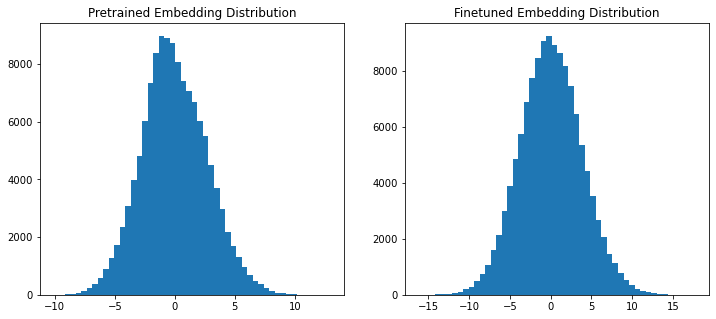

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(pretrained_subsample.numpy().flatten(), bins=50)
plt.title("Pretrained Embedding Distribution")

plt.subplot(122)
plt.hist(finetuned_subsample.numpy().flatten(), bins=50)
plt.title("Finetuned Embedding Distribution")

plt.show()

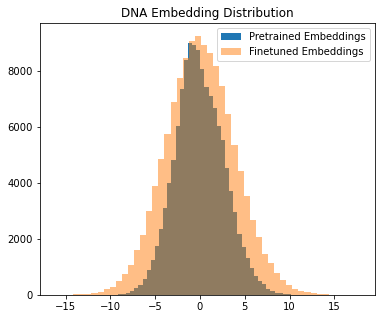

In [25]:
plt.figure(figsize=(6, 5))
plt.hist(pretrained_subsample.numpy().flatten(), bins=50)
plt.hist(finetuned_subsample.numpy().flatten(), bins=50, alpha=0.5)
plt.legend(["Pretrained Embeddings", "Finetuned Embeddings"])
plt.title("DNA Embedding Distribution")
plt.show()

## MDS

In [26]:
WORKERS = 24
SEED = 0

In [27]:
from scipy.spatial import KDTree
from common.metrics import chamfer_distance_matrix, mds, mds_stress_analysis

In order to increase the performance of Chamfer distance, the samples can be converted to KD-trees,
allowing us to compute the chamfer distance in ~O(nlogn) rather than O(n^2).

In [28]:
pretrained_sample_trees = []
finetuned_sample_trees = []
for sample_name in sample_files:
	pretrained_sample_trees += [KDTree(sample) for sample in pretrained_samples[sample_name]]
	finetuned_sample_trees += [KDTree(sample) for sample in finetuned_samples[sample_name]]
len(pretrained_sample_trees)

70

In [29]:
pretrained_dist_mat = chamfer_distance_matrix(pretrained_sample_trees, workers=WORKERS)

In [30]:
finetuned_dist_mat = chamfer_distance_matrix(finetuned_sample_trees, workers=WORKERS)

In [31]:
pretrained_pca, _ = mds(pretrained_dist_mat, seed=SEED)
finetuned_pca, _ = mds(finetuned_dist_mat, seed=SEED)

# Reshape the samples so they are grouped by corresponding samples
pretrained_pca = pretrained_pca.reshape((-1, NUM_SUBSAMPLES_PER_SAMPLE, 2))
finetuned_pca = finetuned_pca.reshape((-1, NUM_SUBSAMPLES_PER_SAMPLE, 2))

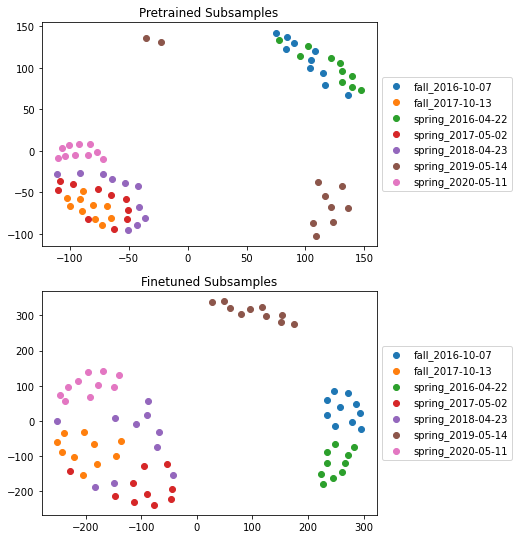

In [32]:
plt.figure(figsize=(6,14))

plt.subplot(311)
for subsample in pretrained_pca:
	plt.scatter(*subsample.T)
plt.legend(sample_files, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Pretrained Subsamples")

plt.subplot(312)
for subsample in finetuned_pca:
	plt.scatter(*subsample.T)
plt.legend(sample_files, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Finetuned Subsamples")

plt.show()

### Stress Analysis

In [33]:
DIMS = pretrain_encoder.base.embed_dim

In [53]:
_, pretrained_stress = mds_stress_analysis(pretrained_dist_mat, DIMS, seed=SEED, workers=WORKERS)
_, finetuned_stress = mds_stress_analysis(finetuned_dist_mat, DIMS, seed=SEED, workers=WORKERS)

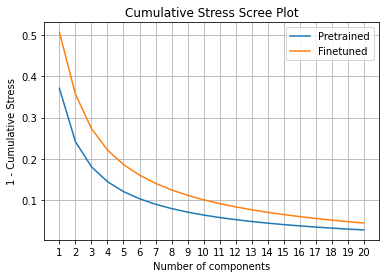

In [54]:
LIMIT = 20

plt.figure()
x_ticks = 1 + np.arange(len(pretrained_stress[:LIMIT]))
plt.plot(x_ticks, pretrained_stress[:LIMIT])
plt.plot(x_ticks, finetuned_stress[:LIMIT])
plt.xticks(x_ticks)
plt.xlabel("Number of components")
plt.ylabel("1 - Cumulative Stress")
plt.legend(["Pretrained", "Finetuned"])
plt.title("Cumulative Stress Scree Plot")
plt.grid()
plt.show()